# SYDE 572 Winter 2024 Assignment 5: Sofiane SIFAOUI (Student ID: 21114530)

## Neural Style Transfer: Comparison of two methods | Gram Matrix and Sliced Wasserstein Distance

#### In this Assignment, we will compare two different methods of neural style transfer. In this "tutorial" notebook, we will show how to use these two different methods for style transfer and also compare and analyze the results obtained. We will also use additional numerical metrics to compare image quality, between the (initial) content image and the resulting style image.

###### Inspired by https://www.tensorflow.org/tutorials/generative/style_transfer and Anis Ayari GitHub

###### Instructions: If you want to experiment with your own images, you will have to create a public GitHub repo, as done in it's notebook. Moreover, if you want to train the SWD style transfer loss, you will have to load the vgg19.pth file from the official implementation on GitHub (A-Sliced-Wasserstein-Loss-for-Neural-Texture-Synthesis)


# Imports and utils functions

In [1]:
import os
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
!pip install -q git+https://github.com/tensorflow/docs

# Utils
import time
import IPython.display as display
import numpy as np
import glob
import time
import functools

# Viz
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
from matplotlib import gridspec

# Image processing
import imageio
import PIL.Image

# Models
import tensorflow as tf
import tensorflow_hub as hub # if needed can use Fast Style Transfer (https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization)


  Preparing metadata (setup.py) ... done


In [2]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image


@functools.lru_cache(maxsize=None)
def load_image(image_url,image_name, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  print(os.path.basename(image_url))
  image_path = tf.keras.utils.get_file(os.path.basename(image_url), image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path)[:,:,:3].astype(np.float32)[np.newaxis, ...]
  print(img.shape)
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img


def show_n(images, titles=('',), download=False):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  fig = plt.gcf()
  fig.savefig('all_images_generated_fast.png')
  plt.show()
  if download == True:
    try:
      from google.colab import files
    except ImportError:
      pass
    else:
      files.download('all_images_generated_fast.png')

# Choice of content and style images

YellowLabradorLooking_new.jpg
83281/83281 [==============================] - 0s 0us/step
(1, 577, 700, 3)


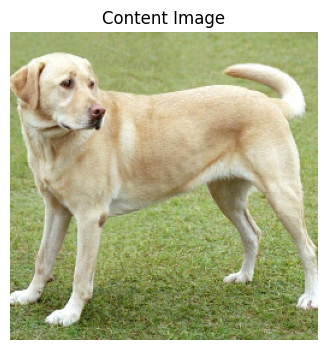

In [3]:
# @title Load content images  { display-mode: "form" ,  run: "auto" }

github_content_image_folder_url = 'https://raw.githubusercontent.com/Sofiane-Sif/StyleTransfer/main/images/content/'  # @param {type:"string"}

content_image_name= 'YellowLabradorLooking_new.jpg'  #@param ["eiffel.jpg","iron_man.jpeg","mona_lisa.jpeg", "paris.jpeg", "pikachu.jpeg", "quartier-japonais.jpg", "san_francisco_bridge.jpeg", "YellowLabradorLooking_new.jpg"]
output_image_size1 = 512  # @param {type:"integer"}
output_image_size2 = 512  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size1, output_image_size2)

content_image_url = os.path.join(github_content_image_folder_url, content_image_name)
content_image = load_image(content_image_url, content_img_size)
show_n([content_image], ['Content Image'])

Vassily.jpeg
195196/195196 [==============================] - 0s 0us/step
(1, 657, 1000, 3)


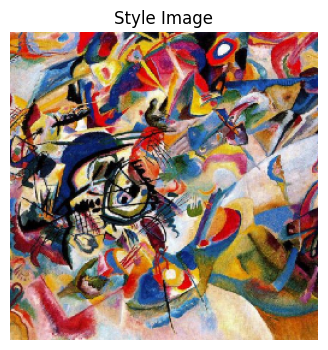

In [4]:
# @title Load style image  { display-mode: "form" ,  run: "auto" }

github_image_folder_url = 'https://raw.githubusercontent.com/Sofiane-Sif/StyleTransfer/main/images/style/'  # @param {type:"string"}

style_image_name = 'Vassily.jpeg'  #@param ["guernica.jpg", "hiroglyphs.jpeg", "monet_water_lilies.jpg", "mosaique_grecque.jpeg", "persistance_dali.jpeg", "picasso_portrait.jpeg", "picasso.jpeg", "van_gogh_nuit.jpeg", "Vassily.jpeg"]
output_image_size = 512  # @param {type:"integer"}

# The style prediction model was trained with image size 256 and it's the
# recommended image size for the style image (though, other sizes work as
# well but will lead to different results).
style_img_size = (output_image_size, output_image_size)  # Recommended to keep it at 256.

style_image_url = os.path.join(github_image_folder_url, style_image_name)

style_image = load_image(style_image_url, style_img_size)
show_n([style_image], ['Style Image'])

# Visualize model's architecture

#### We will use the VGG19 architecture, but we will remove its head (i.e. the classification layers such as Softmax, etc.). Let's take a look at its architecture.

VGG19 layers names: 

80134624/80134624 [==============================] - 1s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool




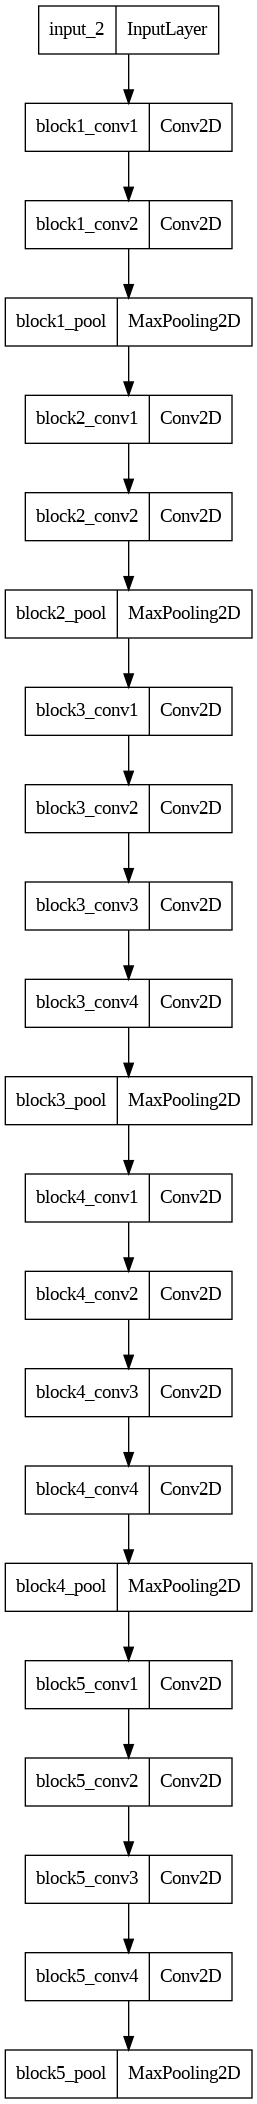

In [5]:
# Print layers names for the VGG19 architecture (trained on ImageNet) only for the backbone:

print("VGG19 layers names: \n")
for layer in tf.keras.applications.VGG19(include_top=False, weights='imagenet').layers:
    print(layer.name)

print("\n")

# Plot the model and visualize its corresponding layers:
tf.keras.utils.plot_model(
    tf.keras.applications.VGG19(include_top=False, weights='imagenet'))

#Define Model

### Choose intermediate layers from the network to represent the style and content of the image:

In [6]:
# We use the same content and style layers than Tensorflow tutorial notebook
# but one can experimenent with other layers, e.g. content_layers = 'block5_conv3'

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

content_layers = ['block5_conv2']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [7]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg =  tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)

  return model

### Gram Matrix implementation (cf. write for explanations and visualization) and loss definition

In [8]:
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

In [9]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)

    outputs = self.vgg(preprocessed_input)

    style_outputs , content_outputs = (outputs[:self.num_style_layers],
                                       outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

    content_dict =  {content_name: value for content_name, value in
                     zip(self.content_layers, content_outputs)}

    style_dict =  {style_name: value for style_name, value in
                     zip(self.style_layers, style_outputs)}


    return {'content': content_dict, 'style': style_dict}

#Training and generation


In [10]:
extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

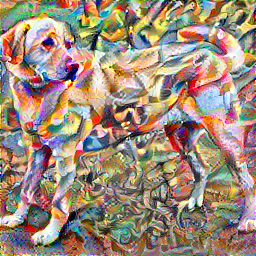

Train step: 1000


In [11]:
!rm stylized-image-*.png

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# Combination between content and style. Do we want something more similar to the
# content image, or very similar to the style but therefore less similar to content?
style_weight=1e-2
content_weight=1e3

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean(tf.square((style_outputs[name]-style_targets[name])))
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean(tf.square((content_outputs[name]-content_targets[name])))
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

opt = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

total_variation_weight=50
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

image = tf.Variable(content_image)
#image = tf.Variable(np.random.rand(1,256,256,3))

epochs = 10
steps_per_epoch = 100
max_step = epochs * steps_per_epoch
step_to_save = max_step*0.1

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
    if step%step_to_save ==0:
        print(f'STEP: {step} SAVING..')
        file_name = f'stylized-image-{step}.png'
        tensor_to_image(image).save(file_name)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

## Sliced Wasserstein Loss NST method

In [3]:
#######################################################################
# Implementation of
# A Sliced Wasserstein Loss for Neural Texture Synthesis
# Heitz et al., CVPR 2021
#######################################################################

import os
import numpy as np
import torch
import imageio
from skimage.transform import resize
import matplotlib.pyplot as plt

SCALING_FACTOR = 1

device = 'cuda' if torch.cuda.is_available() else "cpu"
print(device)

def saveImage(filename, image):
    imageTMP = np.clip(image * 255.0, 0, 255).astype('uint8')
    imageio.imwrite(filename, imageTMP)

def loadImage(filename, resize_to=None):
    image = imageio.v2.imread(filename).astype("float32")[:, :, 0:3] / 255.0

    # If `resize_to` dimensions are provided, resize the image
    if resize_to is not None:
        image = resize(image, resize_to, anti_aliasing=True)
    image = image[np.newaxis, ...]
    return image

def display_image(img: torch.tensor):
    img = np.array(img.cpu().detach().squeeze(0))
    img = img.transpose(2,1,0)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    plt.close()

cuda


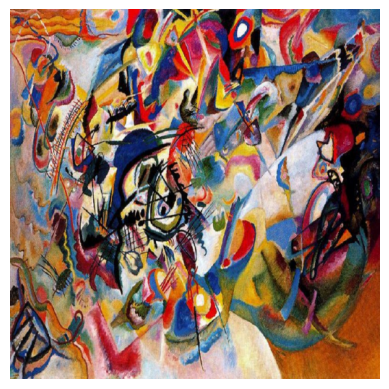

In [4]:
# @title Load style image  { display-mode: "form" ,  run: "auto" }

github_image_folder_url = 'https://raw.githubusercontent.com/Sofiane-Sif/StyleTransfer/main/images/style/'  # @param {type:"string"}

style_image_name = 'Vassily.jpeg'  #@param ["guernica.jpg", "hiroglyphs.jpeg", "monet_water_lilies.jpg", "mosaique_grecque.jpeg", "persistance_dali.jpeg", "picasso_portrait.jpeg", "picasso.jpeg", "van_gogh_nuit.jpeg", "Vassily.jpeg"]
output_image_size = 512  # @param {type:"integer"}

style_img_size = (output_image_size, output_image_size)  # Recommended to keep it at 256.

style_image_url = os.path.join(github_image_folder_url, style_image_name)

style_image_example = loadImage(style_image_url, style_img_size)
style_image_example = np.swapaxes(style_image_example, 1, 3)
style_image_example = torch.from_numpy(style_image_example)
style_image_example = style_image_example.to(torch.device(device))
style_image_example = style_image_example[:, :, 0:(style_image_example.shape[2]//8)*8, 0:(style_image_example.shape[3]//8)*8]

display_image(style_image_example)

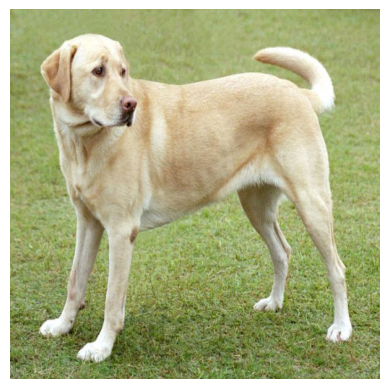

In [5]:
# @title Load content image  { display-mode: "form" ,  run: "auto" }

github_content_image_folder_url = 'https://raw.githubusercontent.com/Sofiane-Sif/StyleTransfer/main/images/content/'  # @param {type:"string"}

content_image_name= 'YellowLabradorLooking_new.jpg'  #@param ["eiffel.jpg","iron_man.jpeg","mona_lisa.jpeg", "paris.jpeg", "pikachu.jpeg", "quartier-japonais.jpg", "san_francisco_bridge.jpeg", "YellowLabradorLooking_new.jpg"]
output_image_size1 = 512  # @param {type:"integer"}
output_image_size2 = 512  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size1, output_image_size2)

content_image_url = os.path.join(github_content_image_folder_url, content_image_name)
content_image_swd = loadImage(content_image_url, content_img_size)

image_optimized = np.swapaxes(content_image_swd, 1, 3)
image_optimized = torch.from_numpy(image_optimized)
image_optimized = image_optimized.to(torch.device(device))
image_optimized = image_optimized[:, :, 0:(image_optimized.shape[2]//8)*8, 0:(image_optimized.shape[3]//8)*8]

image_optimized = torch.nn.parameter.Parameter(image_optimized)


display_image(image_optimized)

## Define model architecture and intermediate feature maps used

In [6]:
class VGG19(torch.nn.Module):

    def __init__(self):
        super(VGG19, self).__init__()

        self.block1_conv1 = torch.nn.Conv2d(3, 64, (3,3), padding=(1,1), padding_mode='reflect')
        self.block1_conv2 = torch.nn.Conv2d(64, 64, (3,3), padding=(1,1), padding_mode='reflect')

        self.block2_conv1 = torch.nn.Conv2d(64, 128, (3,3), padding=(1,1), padding_mode='reflect')
        self.block2_conv2 = torch.nn.Conv2d(128, 128, (3,3), padding=(1,1), padding_mode='reflect')

        self.block3_conv1 = torch.nn.Conv2d(128, 256, (3,3), padding=(1,1), padding_mode='reflect')
        self.block3_conv2 = torch.nn.Conv2d(256, 256, (3,3), padding=(1,1), padding_mode='reflect')
        self.block3_conv3 = torch.nn.Conv2d(256, 256, (3,3), padding=(1,1), padding_mode='reflect')
        self.block3_conv4 = torch.nn.Conv2d(256, 256, (3,3), padding=(1,1), padding_mode='reflect')

        self.block4_conv1 = torch.nn.Conv2d(256, 512, (3,3), padding=(1,1), padding_mode='reflect')
        self.block4_conv2 = torch.nn.Conv2d(512, 512, (3,3), padding=(1,1), padding_mode='reflect')
        self.block4_conv3 = torch.nn.Conv2d(512, 512, (3,3), padding=(1,1), padding_mode='reflect')
        self.block4_conv4 = torch.nn.Conv2d(512, 512, (3,3), padding=(1,1), padding_mode='reflect')

        self.relu = torch.nn.ReLU(inplace=True)
        self.downsampling = torch.nn.AvgPool2d((2,2))

    def forward(self, image):

        # RGB to BGR
        image = image[:, [2,1,0], :, :]

        # [0, 1] --> [0, 255]
        image = 255 * image

        # remove average color
        image[:,0,:,:] -= 103.939
        image[:,1,:,:] -= 116.779
        image[:,2,:,:] -= 123.68

        # block1
        block1_conv1 = self.relu(self.block1_conv1(image))
        block1_conv2 = self.relu(self.block1_conv2(block1_conv1))
        block1_pool = self.downsampling(block1_conv2)

        # block2
        block2_conv1 = self.relu(self.block2_conv1(block1_pool))
        block2_conv2 = self.relu(self.block2_conv2(block2_conv1))
        block2_pool = self.downsampling(block2_conv2)

        # block3
        block3_conv1 = self.relu(self.block3_conv1(block2_pool))
        block3_conv2 = self.relu(self.block3_conv2(block3_conv1))
        block3_conv3 = self.relu(self.block3_conv3(block3_conv2))
        block3_conv4 = self.relu(self.block3_conv4(block3_conv3))
        block3_pool = self.downsampling(block3_conv4)

        # block4
        block4_conv1 = self.relu(self.block4_conv1(block3_pool))
        block4_conv2 = self.relu(self.block4_conv2(block4_conv1))
        block4_conv3 = self.relu(self.block4_conv3(block4_conv2))
        block4_conv4 = self.relu(self.block4_conv4(block4_conv3))

        return [block1_conv1, block1_conv2, block2_conv1, block2_conv2, block3_conv1, block3_conv2, block3_conv3, block3_conv4, block4_conv1, block4_conv2, block4_conv3, block4_conv4]

vgg = VGG19().to(torch.device(device))
vgg.load_state_dict(torch.load("vgg19.pth", map_location=torch.device(device)))

<All keys matched successfully>

In [21]:
optimizer = torch.optim.Adam([image_optimized], lr=0.01)

def slicing_loss(image_generated, style_image_example):

    # generate VGG19 activations
    list_activations_generated = vgg(image_generated)
    list_activations_example   = vgg(style_image_example)

    # iterate over layers
    loss = 0
    for l in range(len(list_activations_example)):
        # get dimensions
        b = list_activations_example[l].shape[0]
        dim = list_activations_example[l].shape[1]
        n = list_activations_example[l].shape[2]*list_activations_example[l].shape[3]
        # linearize layer activations and duplicate example activations according to scaling factor
        activations_example = list_activations_example[l].contiguous().view(b, dim, n).repeat(1, 1, SCALING_FACTOR*SCALING_FACTOR)
        activations_generated = list_activations_generated[l].contiguous().view(b, dim, n*SCALING_FACTOR*SCALING_FACTOR)
        # sample random directions
        Ndirection = dim
        directions = torch.randn(Ndirection, dim).to(torch.device(device))
        directions = directions / torch.sqrt(torch.sum(directions**2, dim=1, keepdim=True))
        # project activations over random directions
        projected_activations_example = torch.einsum('bdn,md->bmn', activations_example, directions)
        projected_activations_generated = torch.einsum('bdn,md->bmn', activations_generated, directions)
        # sort the projections
        sorted_activations_example = torch.sort(projected_activations_example, dim=2)[0]
        sorted_activations_generated = torch.sort(projected_activations_generated, dim=2)[0]
        # L2 over sorted lists
        loss += torch.mean( (sorted_activations_example-sorted_activations_generated)**2 )
    return loss

# LBFGS closure function
def closure():
    optimizer.zero_grad()
    loss = slicing_loss(image_optimized, style_image_example)
    print(f"Loss: {loss.item()}")
    loss.backward()
    return loss

0
tensor(0.2421, device='cuda:0', grad_fn=<AddBackward0>)
1
tensor(0.2196, device='cuda:0', grad_fn=<AddBackward0>)
2
tensor(0.2097, device='cuda:0', grad_fn=<AddBackward0>)
3
tensor(0.2131, device='cuda:0', grad_fn=<AddBackward0>)
4
tensor(0.2242, device='cuda:0', grad_fn=<AddBackward0>)
5
tensor(0.2098, device='cuda:0', grad_fn=<AddBackward0>)
6
tensor(0.2117, device='cuda:0', grad_fn=<AddBackward0>)
7
tensor(0.2139, device='cuda:0', grad_fn=<AddBackward0>)
8
tensor(0.2069, device='cuda:0', grad_fn=<AddBackward0>)
9
tensor(0.2142, device='cuda:0', grad_fn=<AddBackward0>)
10
tensor(0.2116, device='cuda:0', grad_fn=<AddBackward0>)
11
tensor(0.2031, device='cuda:0', grad_fn=<AddBackward0>)
12
tensor(0.1879, device='cuda:0', grad_fn=<AddBackward0>)
13
tensor(0.2037, device='cuda:0', grad_fn=<AddBackward0>)
14
tensor(0.1775, device='cuda:0', grad_fn=<AddBackward0>)
15
tensor(0.1985, device='cuda:0', grad_fn=<AddBackward0>)
16
tensor(0.1916, device='cuda:0', grad_fn=<AddBackward0>)
17
tens

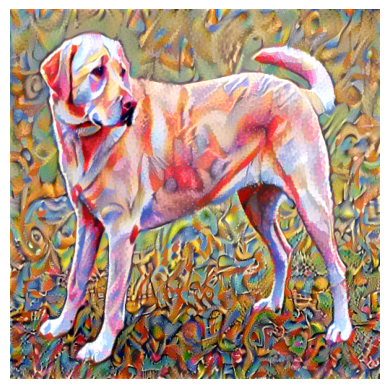

In [22]:
# optimization loop
for iteration in range(128):
    tmp = image_optimized.detach().cpu().clone().numpy()
    tmp = np.swapaxes(tmp, 1, 3)
    print(iteration)
    optimizer.step(closure)

display_image(image_optimized)

# Comparing image quality using SSIM and PSNR

## For the Gram Matrix method

In [12]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

generated_image_arr = np.array(image).squeeze()
content_image_arr = np.array(content_image).squeeze()

ssim_index = ssim(
    generated_image_arr,
    content_image_arr,
    channel_axis=2, # dim 2 represents channel
)

psnr_value = psnr(content_image_arr, generated_image_arr)


print(f"GRAM MATRIX - SSIM: {ssim_index}")
print(f"GRAM MATRIX - PSNR: {psnr_value} dB")


GRAM MATRIX - SSIM: 0.2752472758293152
GRAM MATRIX - PSNR: 13.348374005383825 dB


## For the SWD method

In [24]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

generated_image_arr = np.array(image_optimized.cpu().detach()).squeeze(0)
content_image_arr = np.array(content_image_swd).squeeze(0)
content_image_arr = np.swapaxes(content_image_arr, 0, 2)

ssim_index = ssim(
    generated_image_arr,
    content_image_arr,
    channel_axis=0, # dim 0 represents channel
)

psnr_value = psnr(content_image_arr, generated_image_arr)


print(f"SWD - SSIM: {ssim_index}")
print(f"SWD - PSNR: {psnr_value} dB")

SWD - SSIM: 0.5216733813285828
SWD - PSNR: 16.135686988242647 dB


In [ ]:
# @title Save and download generated image...  { display-mode: "form" }

print('SAVING AND DOWNLOADING GENERATED IMAGE...')
file_name = f'stylized-image-{step}.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

print('SAVING AND DOWNLOADING GENERATED IMAGE DONE')

SAVING AND DOWNLOADING GENERATED IMAGE...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

SAVING AND DOWNLOADING GENERATED IMAGE DONE
